<a href="https://colab.research.google.com/github/AnhelinaKavaliova/MachineLearning/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**EDA** house prices


Подключение библиотек и скриптов

In [ ]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модель
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

Путь к файлу

In [ ]:
df = pd.read_csv('./price_dataset/train.csv')
PREPARED_DATASET_PATH = './price_dataset/train_prepared.csv'

REPORTS_FILE_PATH = './price_dataset/reports/'
SCALER_FILE_PATH = './price_dataset/models/scaler1.pkl'
MODEL_FILE_PATH = './price_dataset/models/model.pkl'

##Загрузка данных

Описание датасета:

**Id:** Уникальный идентификатор объекта

**DistrictId:** Идентификатор района, в котором находится объект

**Rooms:** Количество комнат в квартире или жилом помещении

**Square:** Общая площадь квартиры или жилого помещения

**LifeSquare:** Жилая площадь (комнаты)

**KitchenSquare:** Площадь кухни

**Floor:** Этаж, на котором находится квартира или жилое помещение

**HouseFloor:** Общее количество этажей в доме, в котором находится квартира или жилое помещение

**HouseYear:** Год постройки дома

**Ecology_1, Ecology_2, Ecology_3:** Показатели экологической среды в районе

**Social_1, Social_2, Social_3:** Социальные показатели в районе

**Healthcare_1, Helthcare_2:** Показатель медицинских учреждений в районе

**Shops_1, Shops_2:** Информация о наличии торговых центров или магазинов в районе

**Price:** Цена объекта недвижимости

In [ ]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027311,NaN,10,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.8711
1,3013,22,1,39.832524,23.169223,8,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.5534
2,8215,1,3,78.342215,47.671972,10,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.7209
3,2352,1,1,40.409907,NaN,1,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.0076
4,13866,94,2,64.285067,38.562517,9,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.1030


##Уменьшение объема памяти, который занимает датасет

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.33 MB
Decreased by 78.1%


In [ ]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms                int8
Square            float16
LifeSquare        float16
KitchenSquare       int16
Floor                int8
HouseFloor           int8
HouseYear           int32
Ecology_1         float16
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float16
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

##1. Распределение целевой переменной

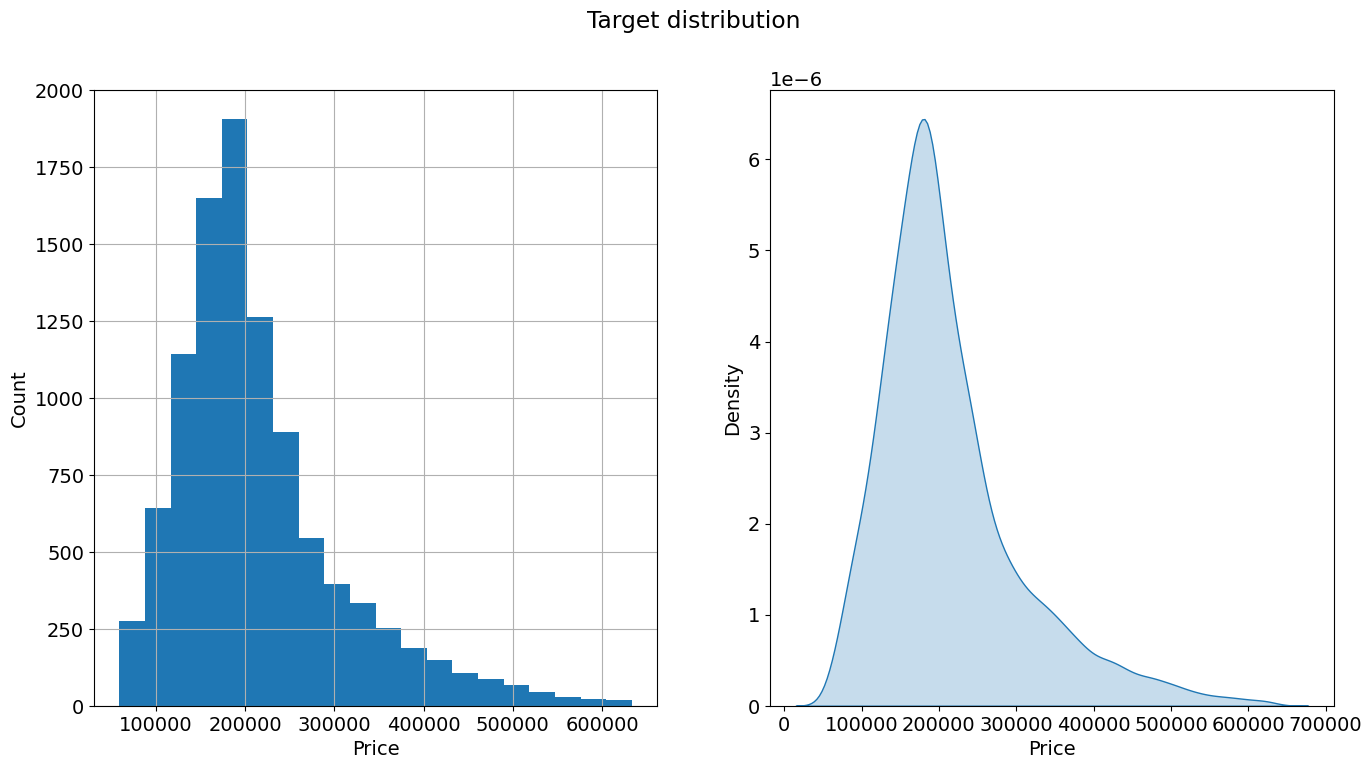

In [ ]:
plt.figure(figsize = (16,8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade = True, legend = False)
plt.xlabel('Price')

plt.suptitle('Target distribution')
plt.show()

In [ ]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]
print(f'mean -{target_mean}, mediana - {target_median}, mode - {target_mode}')

mean -214138.859375, mediana - 192269.65625, mode - 182938.078125


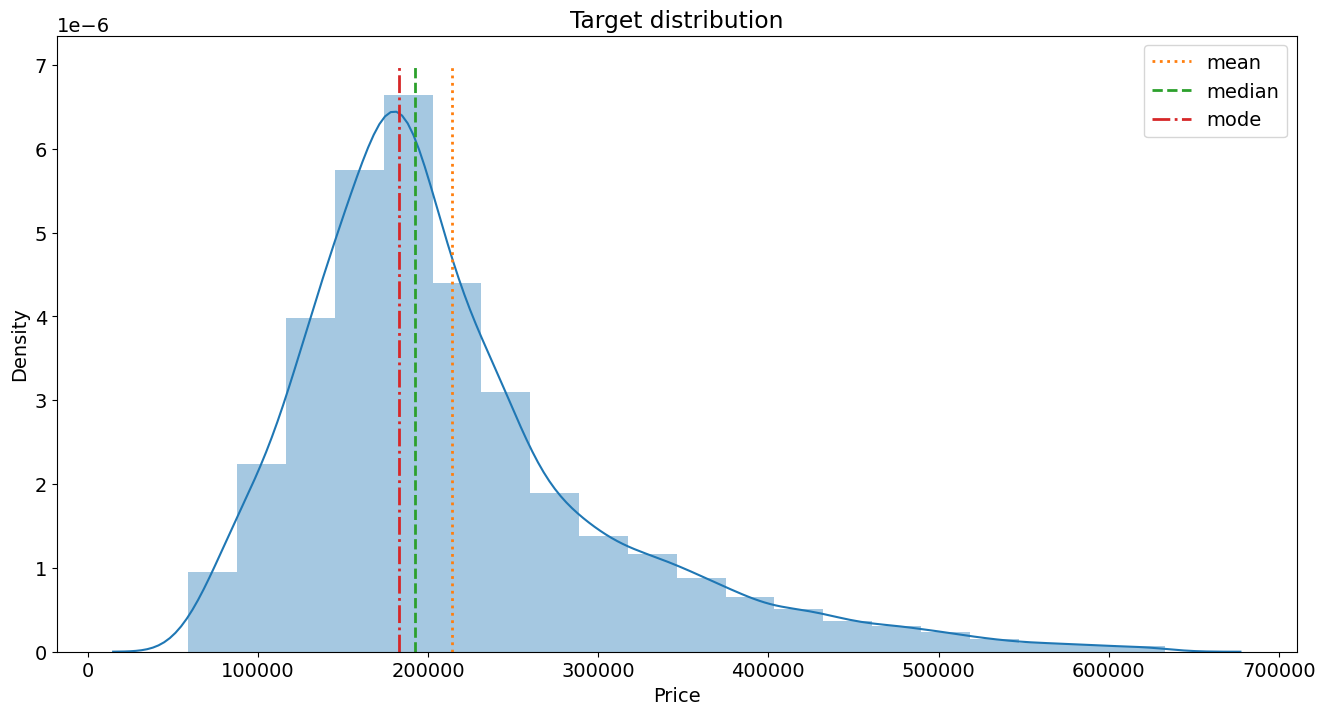

In [ ]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=20)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=2)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=2)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=2)

plt.title('Target distribution')
plt.legend()
plt.show()

##2. Анализ признаков

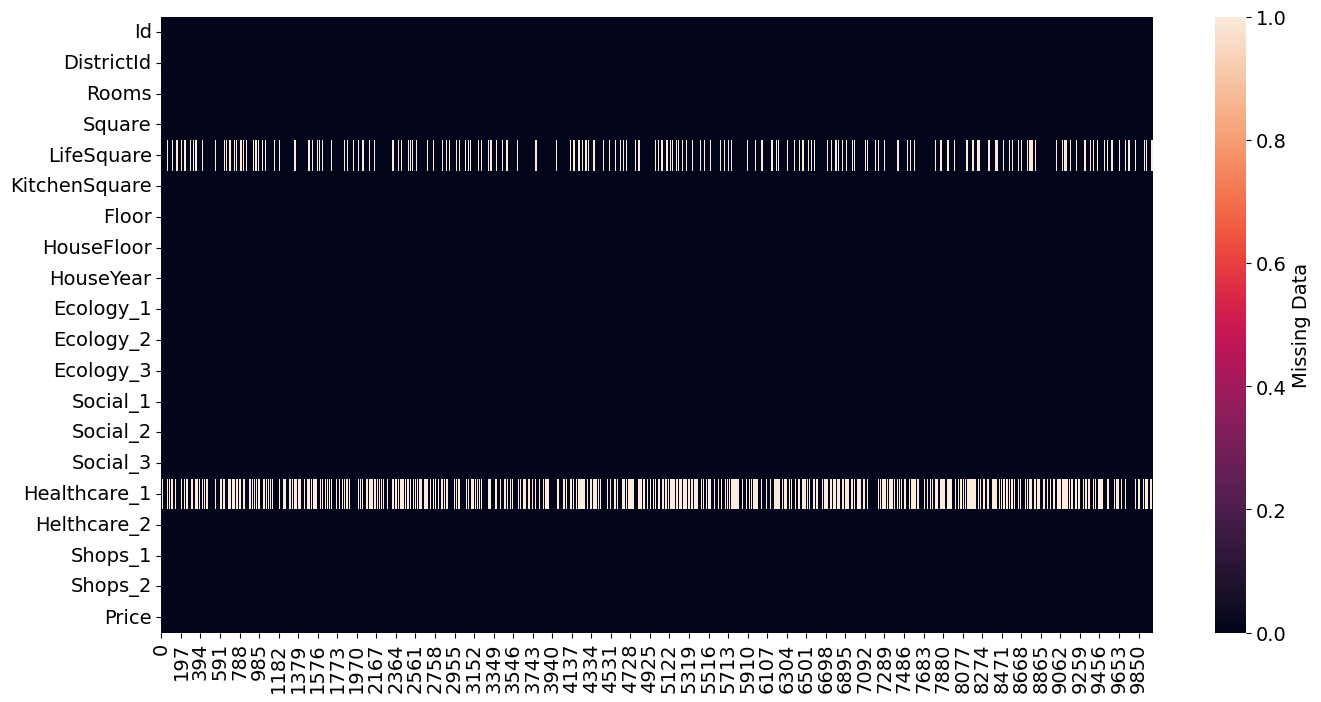

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isna().transpose(),
            cbar_kws={'label': 'Missing Data'});

Большое количество пропущенных значений в признаке 'LifeSquare' представляет собой проблему для анализа данных и построения модели. Пропуски в этом признаке могут привести к искажению результатов и уменьшению точности модели, поскольку жилая площадь является важным аспектом оценки недвижимости

**Количественные признаки**

In [ ]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32'])

df_num_features.drop(['Price', 'Id', 'DistrictId'], axis=1, inplace=True)

In [ ]:
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3,115.000000,NaN,10,4,10,2014,0.075439,11,3097,0,NaN,0,0
1,1,39.843750,23.171875,8,7,8,1966,0.118530,30,6207,1,1183.0,1,0
2,3,78.312500,47.687500,10,2,17,1988,0.025604,33,5261,0,240.0,3,1
3,1,40.406250,NaN,1,10,22,1977,0.007122,1,264,0,NaN,0,1
4,2,64.312500,38.562500,9,16,16,1972,0.282715,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,49.093750,33.281250,6,3,12,1981,0.300293,52,10311,6,NaN,1,9
9996,2,64.312500,37.031250,9,13,0,1977,0.072144,2,629,1,NaN,0,0
9997,1,29.640625,16.562500,5,3,5,1958,0.460449,20,4386,14,NaN,1,5
9998,1,32.343750,22.328125,5,3,9,1969,0.194458,47,8004,3,125.0,3,5


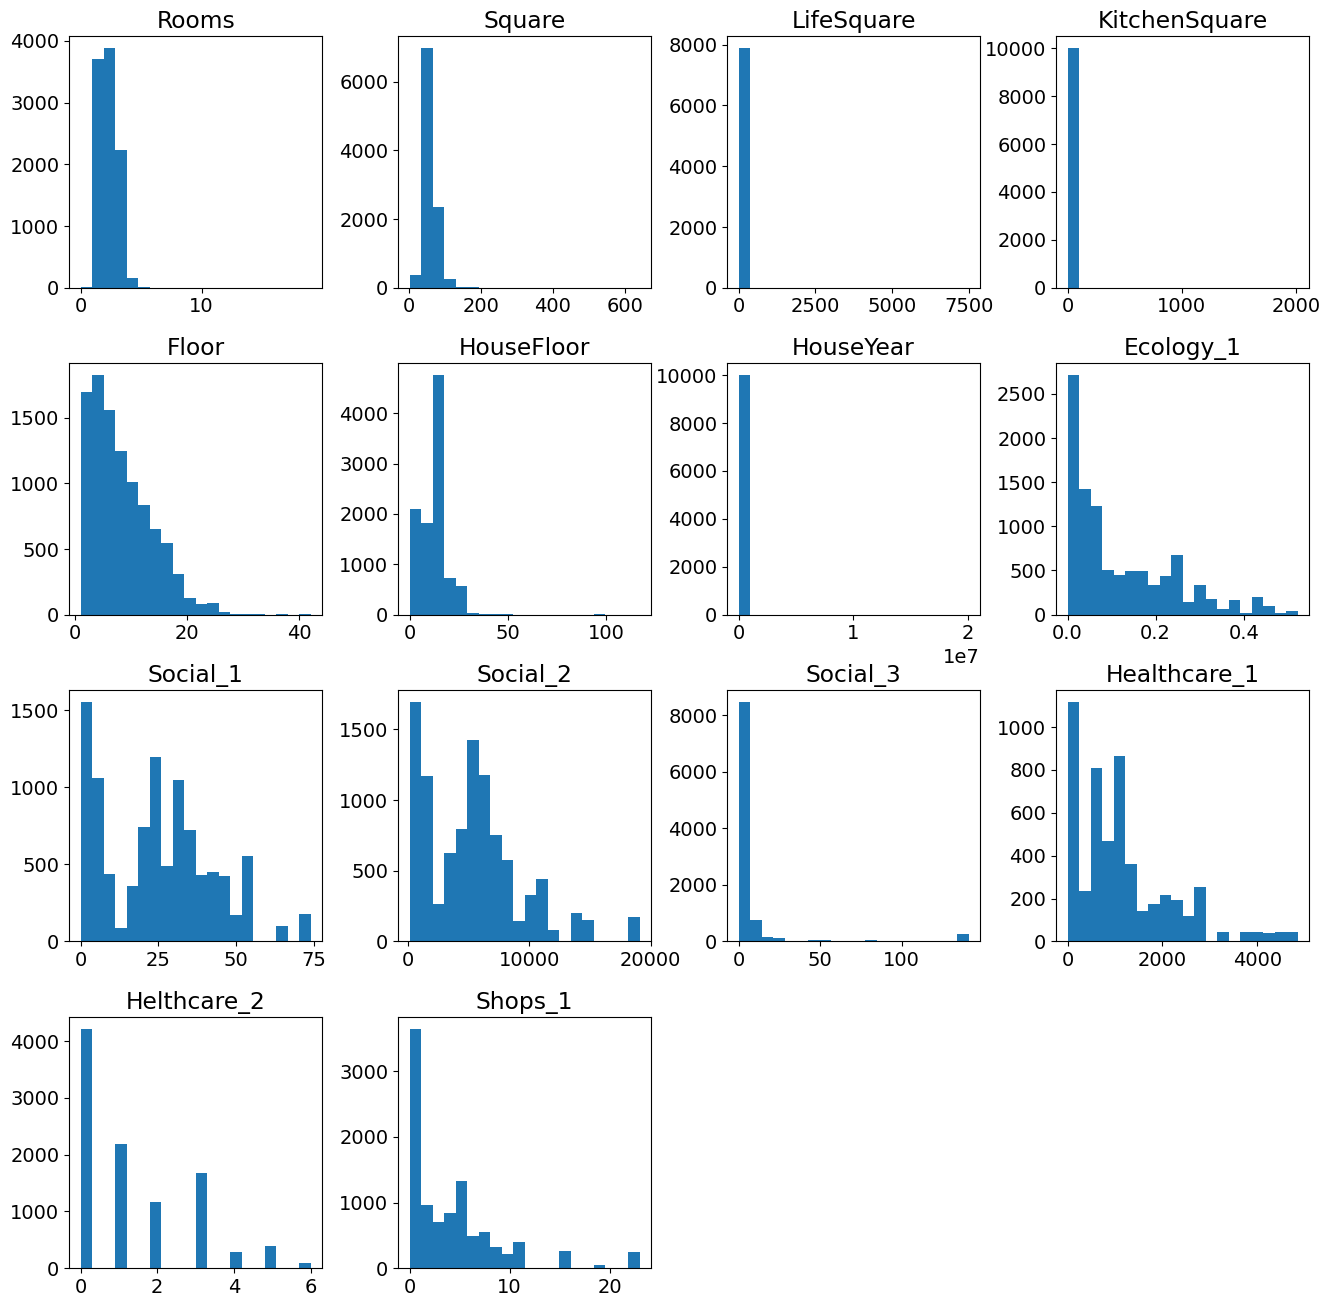

In [ ]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

1. Выбросы в количестве комнат
2. Показатели Square и LifeSquare не могут равняться нулю
3. Количество этажей в доме (HouseFloor) не может быть меньше этажа (Floor)
4. Проверить год постройки на возможность существования
5. Пустые значения в Healthcare_1



**1.Выбросы в количестве комнат**

0 - неверное значение

In [ ]:
df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [ ]:
df['Rooms'].value_counts()

Rooms
2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: count, dtype: int64

In [ ]:
median_rooms = df['Rooms'].median()
df.loc[df['Rooms'] == 0, 'Rooms'] = median_rooms
df.loc[df['Rooms'] > 6, 'Rooms'] = median_rooms

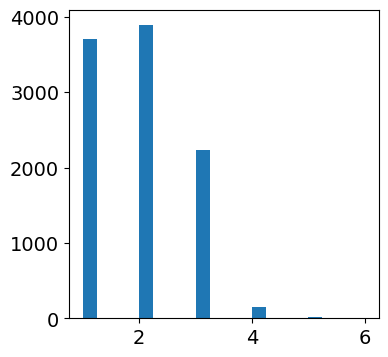

In [ ]:
df['Rooms'].hist(figsize=(4,4), bins=20, grid=False);

**2. Показатели Square и LifeSquare не могут равняться нулю**

In [ ]:
min_Square = df['Square'].min()
max_Square = df['Square'].max()

print(f'min_Square - {min_Square}, max_Square - {max_Square}')

min_Square - 1.13671875, max_Square - 641.0


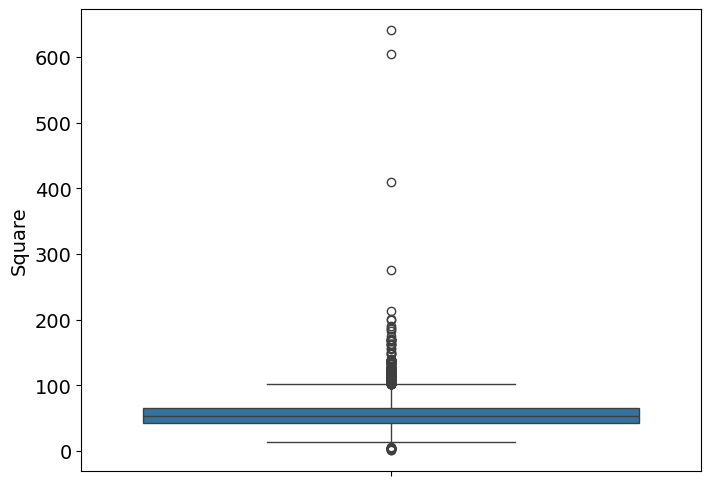

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(df['Square'], whis=1.5)

plt.show()


Учитывая, что Square должно быть больше LifeSquare и KitchenSquare в сумме, возьмём за минимальное значение 20, максимальное 120

In [ ]:
df.loc[df['Square'] < 20, 'Square'] = 20
df.loc[df['Square'] > 120, 'Square'] = 120

Text(0.5, 1.0, 'Square distribution')

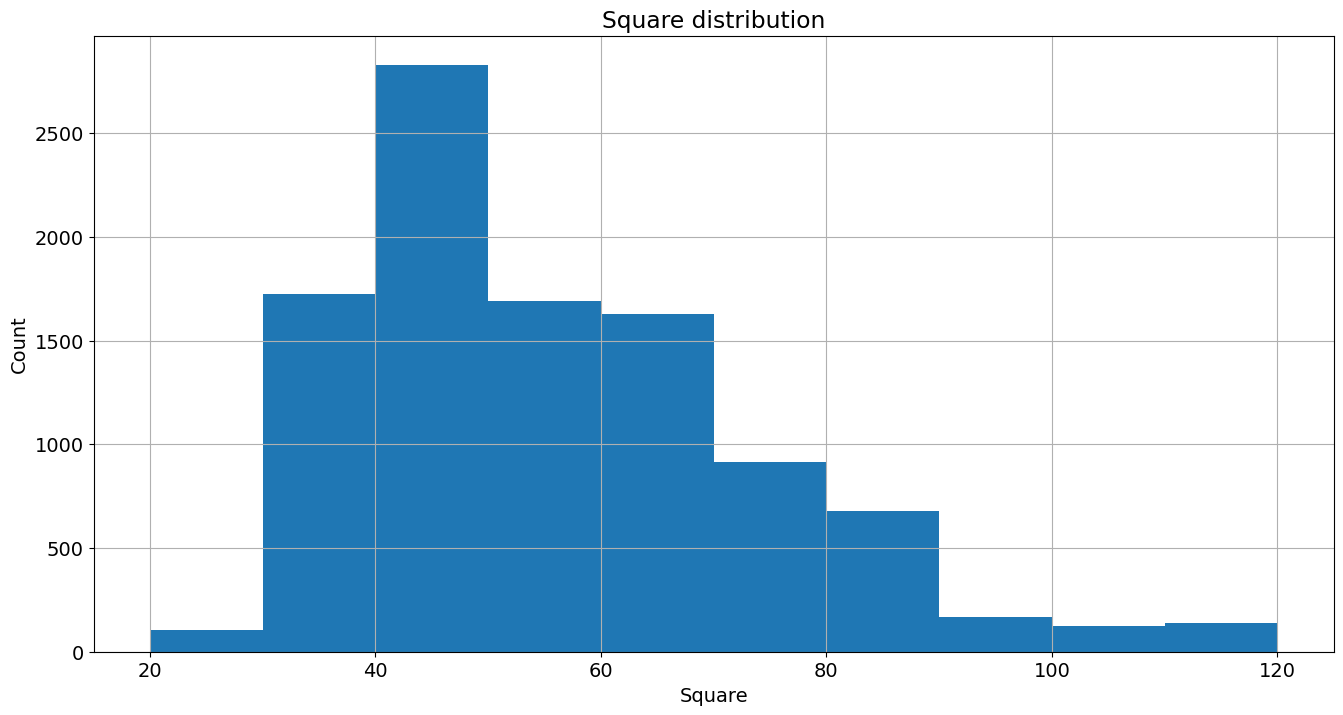

In [ ]:
plt.figure(figsize = (16, 8))
df['Square'].hist()
plt.ylabel('Count')
plt.xlabel('Square')
plt.title('Square distribution')

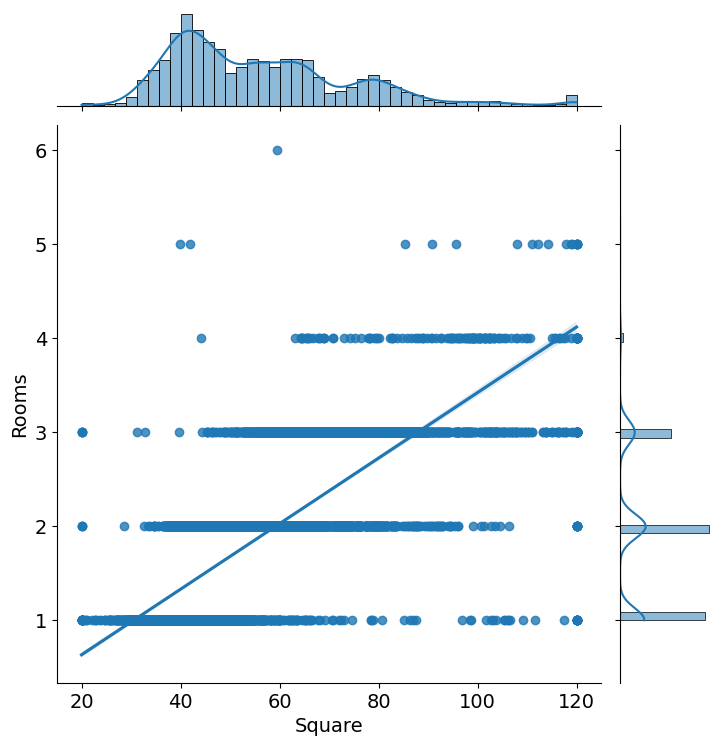

In [ ]:
grid = sns.jointplot(x=df['Square'], y=df['Rooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Линейной зависимости между общей площадью и количеством комнат нет

Text(0.5, 1.0, 'KitchenSquare distribution')

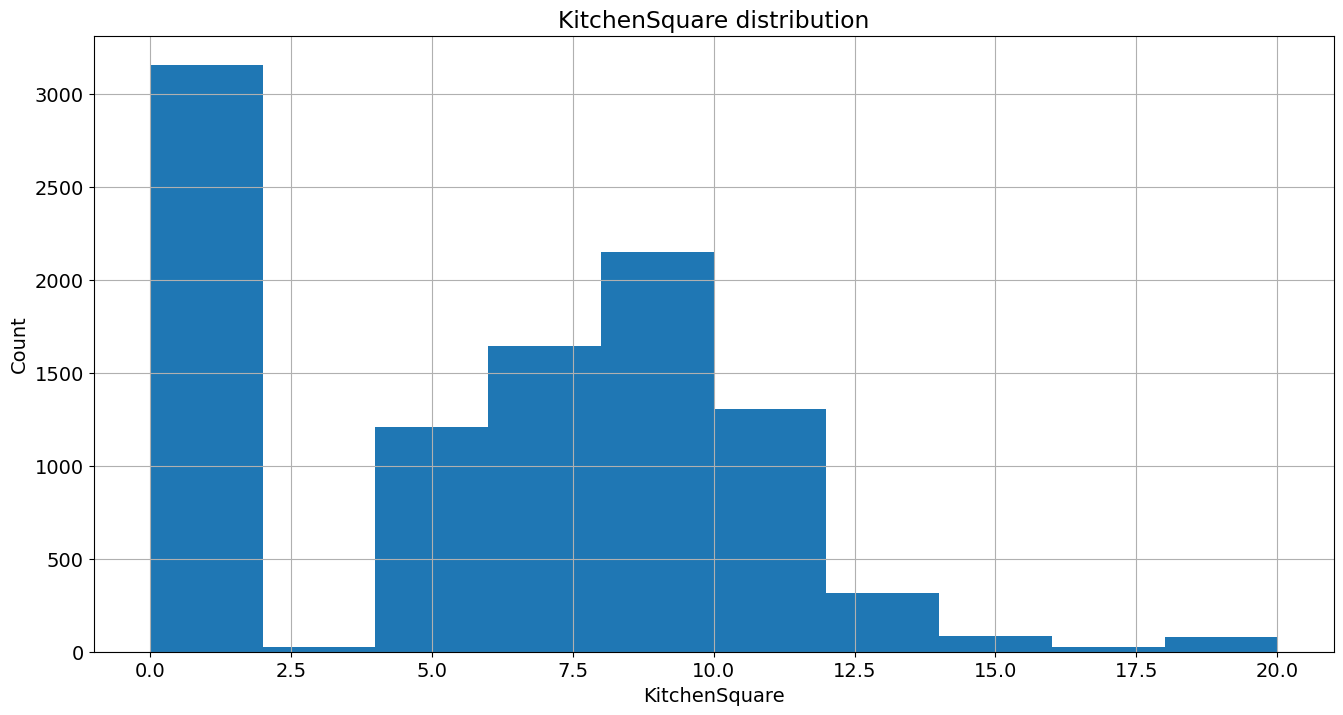

In [ ]:
df['KitchenSquare'].loc[df['KitchenSquare'] > 20] = 20
plt.figure(figsize = (16, 8))
df['KitchenSquare'].hist()
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.title('KitchenSquare distribution')

Избавимся от странных значений

In [ ]:
median_kitchen_square = df['KitchenSquare'].median()
df['KitchenSquare'].loc[df['KitchenSquare'] > 15] = median_kitchen_square
df['KitchenSquare'].loc[df['KitchenSquare'] < 4] = median_kitchen_square


In [ ]:
all(df['Square'] > df['KitchenSquare'])

True

Значения LifeSquare должны быть <= Square - KitchenSquare, а также не иметь пустые значения

Text(0.5, 1.0, 'LifeSquare distribution')

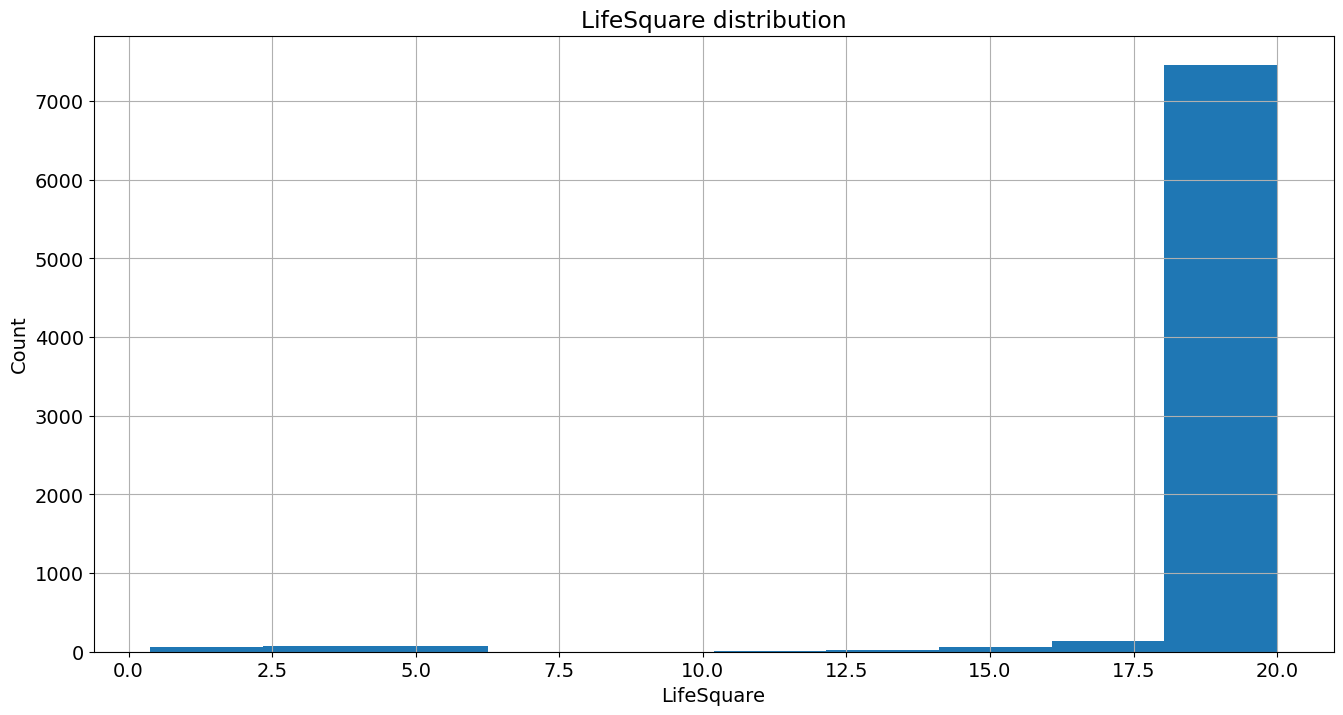

In [ ]:
df['LifeSquare'].loc[df['LifeSquare'] > 20] = 20
plt.figure(figsize = (16, 8))
df['LifeSquare'].hist()
plt.ylabel('Count')
plt.xlabel('LifeSquare')
plt.title('LifeSquare distribution')

In [ ]:
dif_square_kitchen = df['Square'] - df['KitchenSquare']
df.loc[df['LifeSquare'] > dif_square_kitchen, 'LifeSquare'] = dif_square_kitchen
df.loc[df['LifeSquare'] < 5, 'LifeSquare'] = dif_square_kitchen
df['LifeSquare'].fillna(dif_square_kitchen, inplace = True)

In [ ]:
selected_columns = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']
df_selected = df[selected_columns]

In [ ]:
df_selected

,Rooms,Square,LifeSquare,KitchenSquare
0,3,115.000000,105.00000,10
1,1,39.843750,20.00000,8
2,3,78.312500,20.00000,10
3,1,40.406250,34.40625,6
4,2,64.312500,20.00000,9
...,...,...,...,...
9995,2,49.093750,20.00000,6
9996,2,64.312500,20.00000,9
9997,1,29.640625,16.56250,5
9998,1,32.343750,20.00000,5


In [ ]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  int8   
 1   Square         10000 non-null  float16
 2   LifeSquare     10000 non-null  float16
 3   KitchenSquare  10000 non-null  int16  
dtypes: float16(2), int16(1), int8(1)
memory usage: 68.5 KB


**3. Количество этажей в доме (HouseFloor) не может быть меньше этажа (Floor)**

In [ ]:
df.loc[df['HouseFloor'] == 0, 'Floor'] = 0
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor'] - 1

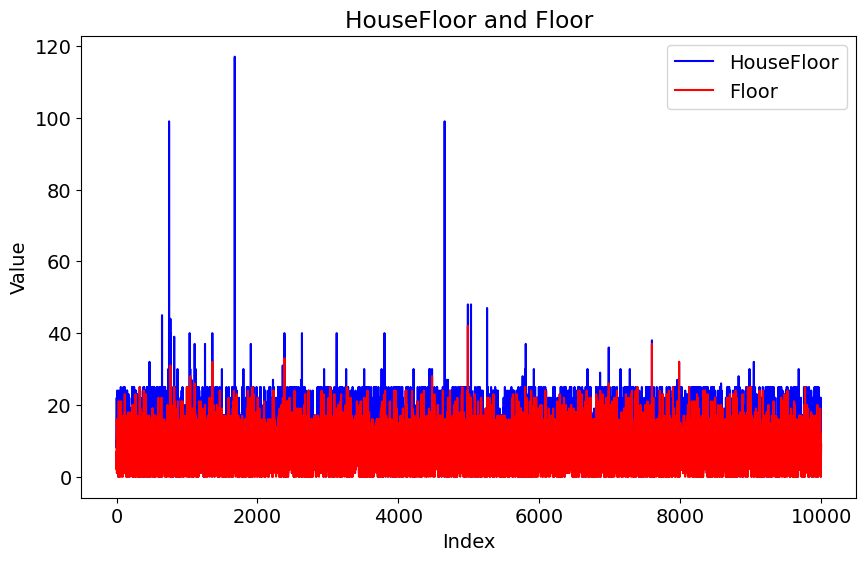

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['HouseFloor'], label='HouseFloor', color='blue')
plt.plot(df['Floor'], label='Floor', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('HouseFloor and Floor')
plt.legend()
plt.show()

**4. Проверить год постройки на возможность существования**

In [ ]:
df['HouseYear'].value_counts().sort_index(ascending=True)

HouseYear
1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: count, Length: 97, dtype: int64

In [ ]:
median_HouseYear = df['HouseYear'].median()
df.loc[df['HouseYear'] > 2024, 'HouseYear'] = median_HouseYear

**5. Пустые значения в Healthcare_1**

Предположим, что значения Healthcare_1 совпадают или близки по значению у домов на одной улице

In [ ]:
healthcare_stats = df.groupby('DistrictId')['Healthcare_1'].describe()


In [ ]:
healthcare_stats

,count,mean,std,min,25%,50%,75%,max
DistrictId,,,,,,,,
0,48.0,inf,inf,645.0,645.0,2856.0,2856.0,2856.0
1,57.0,228.75,18.125,200.0,200.0,240.0,240.0,240.0
2,59.0,inf,inf,900.0,900.0,990.0,2620.0,2620.0
3,82.0,644.50,inf,30.0,30.0,30.0,1937.0,2716.0
4,11.0,2082.00,inf,1046.0,1940.0,2500.0,2500.0,2500.0
...,...,...,...,...,...,...,...,...
202,2.0,4704.00,0.000,4704.0,4704.0,4704.0,4704.0,4704.0
205,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,1.0,1815.00,NaN,1815.0,1815.0,1815.0,1815.0,1815.0


Остаются улицы с NaN значениями. Заменим тогда все нулевые значения на нуль

In [ ]:
df['Healthcare_1'].fillna(0, inplace = True)

**Категориальные признаки**

1. Ecology_2
2. Ecology_3
3. Shops_2

In [ ]:
df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [ ]:
df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

Значением "A" можно пренебречь

In [ ]:
df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

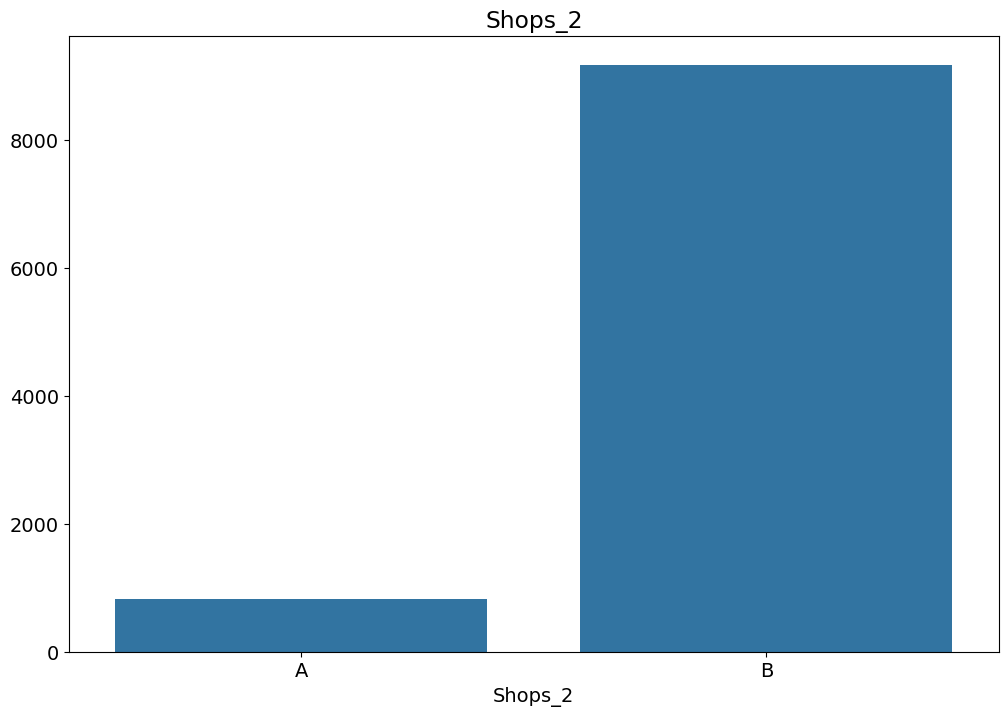

In [ ]:
counts = df['Shops_2'].value_counts()
plt.figure(figsize=(12,8))
plt.title('Shops_2')
sns.barplot(x=counts.index, y=counts.values)
plt.show()


Переведём в бинарный формат

In [ ]:
bin_shop_2 = {'A': 0, 'B': 1}
df['Shops_2_bin'] = df['Shops_2'].map(bin_shop_2).astype('int8')

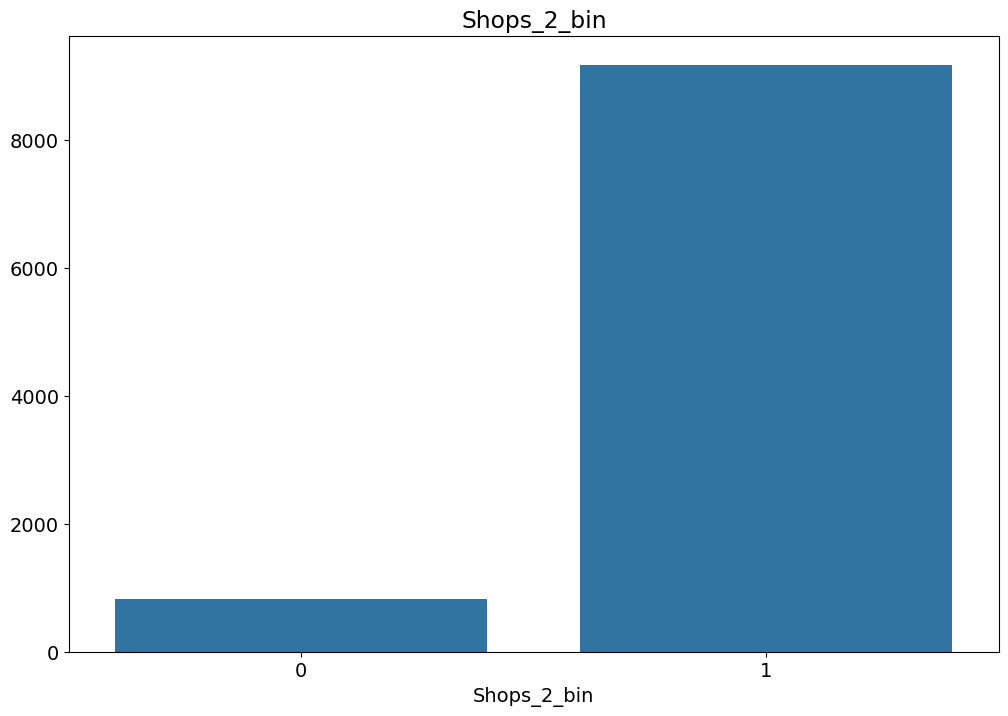

In [ ]:
counts = df['Shops_2_bin'].value_counts()
plt.figure(figsize=(12,8))
plt.title('Shops_2_bin')
sns.barplot(x = counts.index, y =counts.values)

plt.show()

**Матрица корреляций**

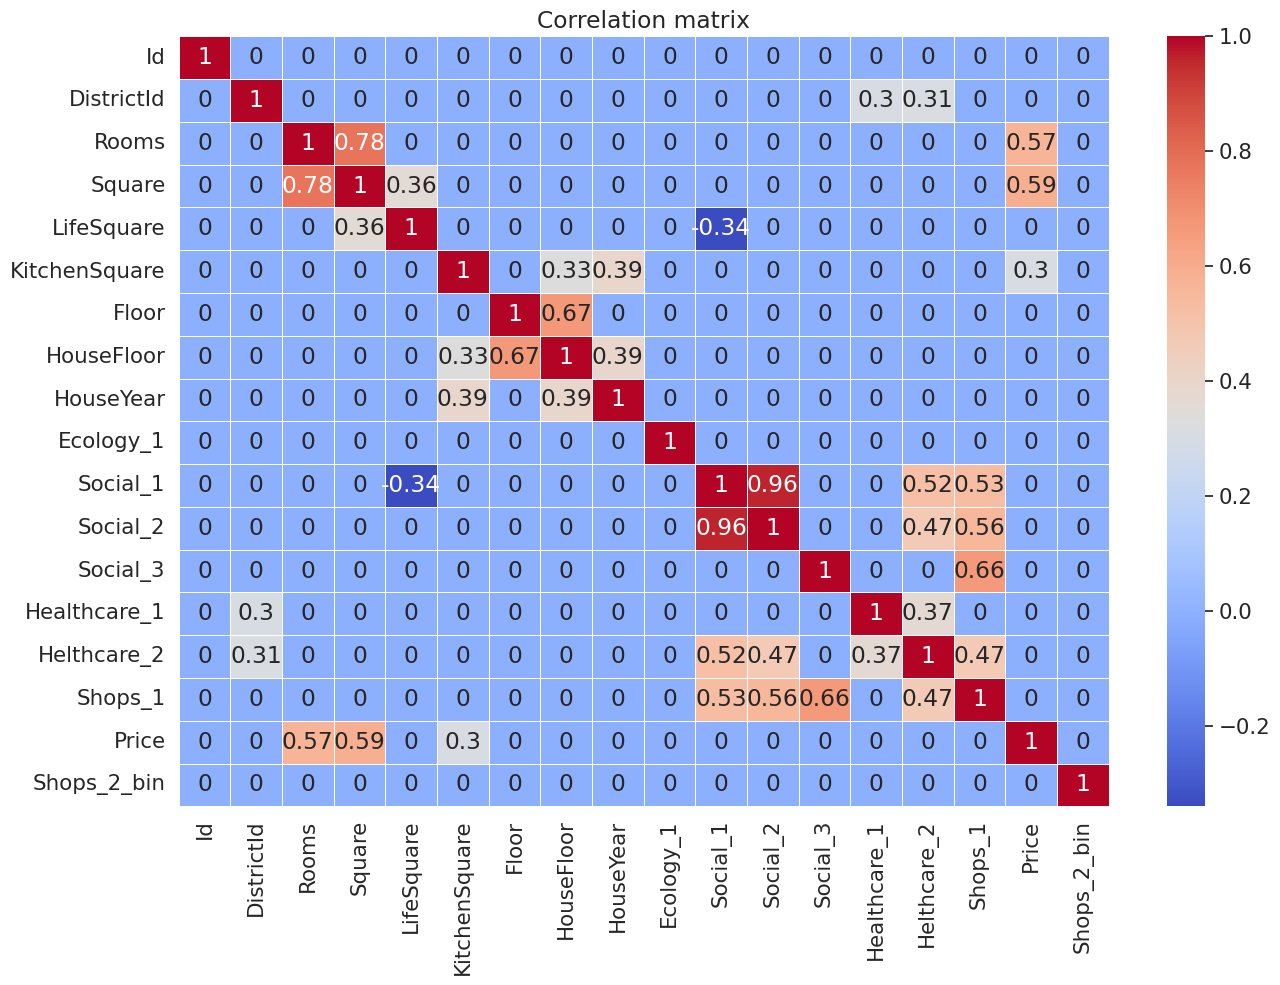

In [ ]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

numerical_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32'])
corr_matrix = numerical_features.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

##3. Анализ зависимости таргета от фичей

По корреляционной матрице у Price наиболее выражена зависимость от Rooms и Square, что довольно логично на смысловом уровне

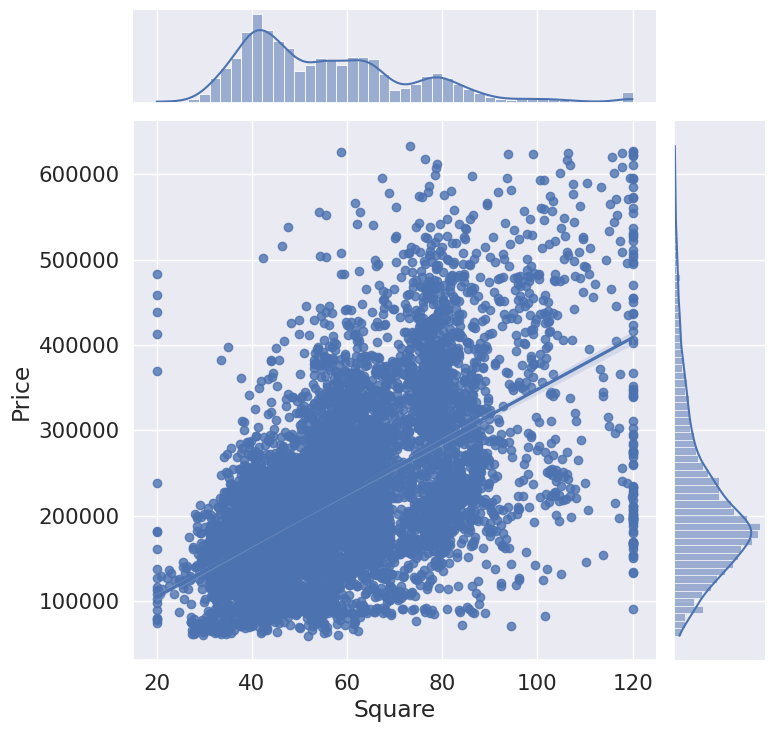

In [ ]:
grid = sns.jointplot(x = df['Square'], y = df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

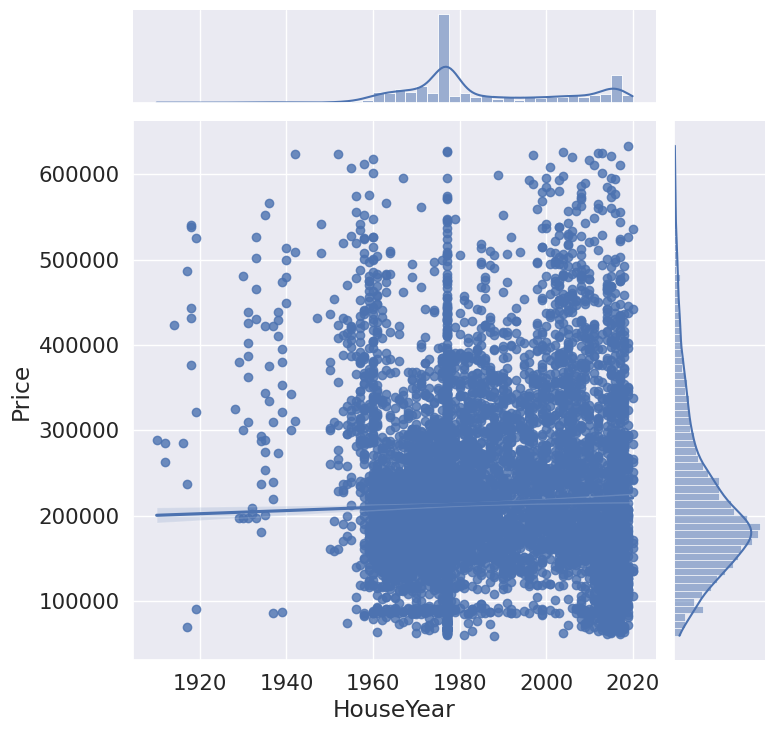

In [ ]:
grid = sns.jointplot(x = df['HouseYear'], y = df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Наибольшее количество по более дорогой цене покупают дома 1960, 1975 и 2000+

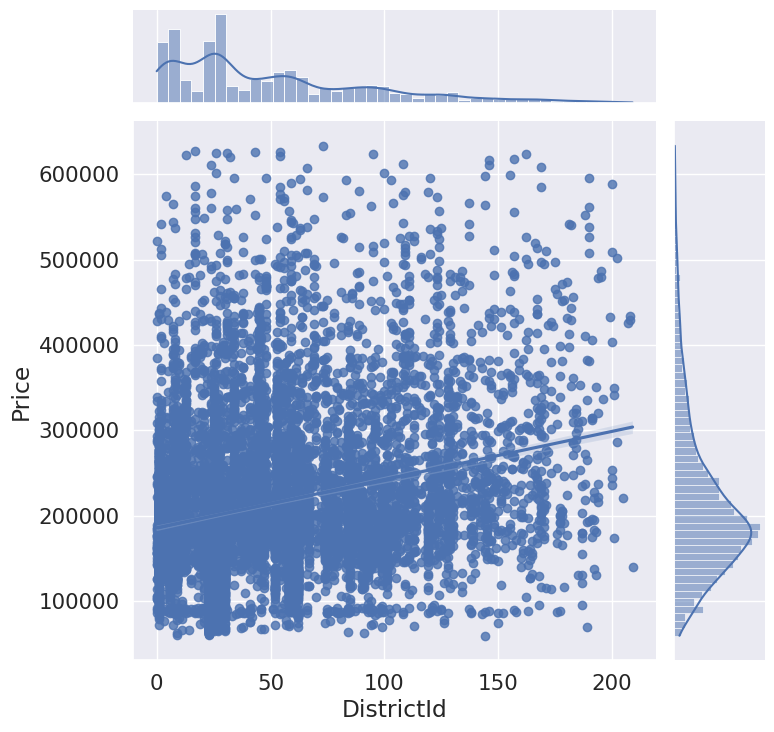

In [ ]:
grid = sns.jointplot(x = df['DistrictId'], y = df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

На определённых улицах явно видно больше дешёвых или дорогих жилых помещений

##4. Сохранение

In [ ]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Shops_2_bin
0,11809,27,3,115.00000,105.00000,10,4,10,2014,0.075439,...,B,11,3097,0,0.0,0,0,B,305018.875000,1
1,3013,22,1,39.84375,20.00000,8,7,8,1966,0.118530,...,B,30,6207,1,1183.0,1,0,B,177734.546875,1
2,8215,1,3,78.31250,20.00000,10,2,17,1988,0.025604,...,B,33,5261,0,240.0,3,1,B,282078.718750,1
3,2352,1,1,40.40625,34.40625,6,10,22,1977,0.007122,...,B,1,264,0,0.0,0,1,B,168106.000000,1
4,13866,94,2,64.31250,20.00000,9,16,16,1972,0.282715,...,B,33,8667,2,0.0,0,6,B,343995.093750,1


In [ ]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

##5. DataPipeline

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
class DataPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.target_mean = None
        self.target_median = None
        self.target_mode = None
        self.median_rooms = None
        self.median_kitchen_square = None
        self.median_HouseYear = None
        self.bin_shop_2 = None

    def fit(self, df):
        """Сохранение статистик"""

        # Расчет медиан
        self.medians = df[['Rooms', 'Square', 'KitchenSquare', 'LifeSquare', 'HouseFloor', 'HouseYear', 'Healthcare_1']].median()
        self.target_mean = round(df['Price'].mean(), 2)
        self.target_median = df['Price'].median()
        self.target_mode = df['Price'].mode()[0]
        self.median_rooms = df['Rooms'].median()
        self.median_kitchen_square = df['KitchenSquare'].median()
        self.median_HouseYear = df['HouseYear'].median()
        self.bin_shop_2 = {'A': 0, 'B': 1}

    def transform(self, df):
        """Трансформация данных"""

        # Заполнение пропусков и обработка выбросов
        df.loc[df['Rooms'] == 0, 'Rooms'] = self.median_rooms
        df.loc[df['Rooms'] > 6, 'Rooms'] = self.median_rooms

        df.loc[df['Square'] < 20, 'Square'] = 20
        df.loc[df['Square'] > 120, 'Square'] = 120

        df['KitchenSquare'].loc[df['KitchenSquare'] > 15] = self.median_kitchen_square
        df['KitchenSquare'].loc[df['KitchenSquare'] < 4] = self.median_kitchen_square

        dif_square_kitchen = df['Square'] - df['KitchenSquare']
        df.loc[df['LifeSquare'] > dif_square_kitchen, 'LifeSquare'] = dif_square_kitchen
        df.loc[df['LifeSquare'] < 5, 'LifeSquare'] = dif_square_kitchen
        df['LifeSquare'].fillna(dif_square_kitchen, inplace = True)

        df.loc[df['HouseFloor'] == 0, 'Floor'] = 0
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor'] - 1

        df.loc[df['HouseYear'] > 2024, 'HouseYear'] = self.median_HouseYear

        df['Healthcare_1'].fillna(0, inplace = True)

        bin_shop_2 = {'A': 0, 'B': 1}
        df['Shops_2_bin'] = df['Shops_2'].map(bin_shop_2).astype('int8')

        return df


In [ ]:
DATASET_PATH = './price_dataset/train.csv'
PREPARED_DATASET_PATH = './price_dataset/train_prepared.csv'

In [ ]:
df = pd.read_csv(DATASET_PATH)

pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)

df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [ ]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Shops_2_bin
0,11809,27,3,115.027311,105.027311,10,4,10,2014,0.075424,...,B,11,3097,0,0.0,0,0,B,305018.8711,1
1,3013,22,1,39.832524,23.169223,8,7,8,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.5534,1
2,8215,1,3,78.342215,47.671972,10,2,17,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.7209,1
3,2352,1,1,40.409907,34.409907,6,10,22,1977,0.007122,...,B,1,264,0,0.0,0,1,B,168106.0076,1
4,13866,94,2,64.285067,38.562517,9,16,16,1972,0.282798,...,B,33,8667,2,0.0,0,6,B,343995.1030,1


In [ ]:
df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Shops_2_bin      0
dtype: int64

##6. Разбиение на train / test

In [ ]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
                 'Shops_1','Shops_2_bin']

target_name = 'Price'

In [ ]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,27,3,115.027311,105.027311,10,4,10,2014,0.075424,11,3097,0,0.0,0,0,1,305018.8711
1,22,1,39.832524,23.169223,8,7,8,1966,0.118537,30,6207,1,1183.0,1,0,1,177734.5534
2,1,3,78.342215,47.671972,10,2,17,1988,0.025609,33,5261,0,240.0,3,1,1,282078.7209
3,1,1,40.409907,34.409907,6,10,22,1977,0.007122,1,264,0,0.0,0,1,1,168106.0076
4,94,2,64.285067,38.562517,9,16,16,1972,0.282798,33,8667,2,0.0,0,6,1,343995.1030


In [ ]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

##7. Построение моделей

In [ ]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""

    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

    plt.figure(figsize=(8,8))

    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.959
RMSE:	18506.202
MSE:	342479507.02


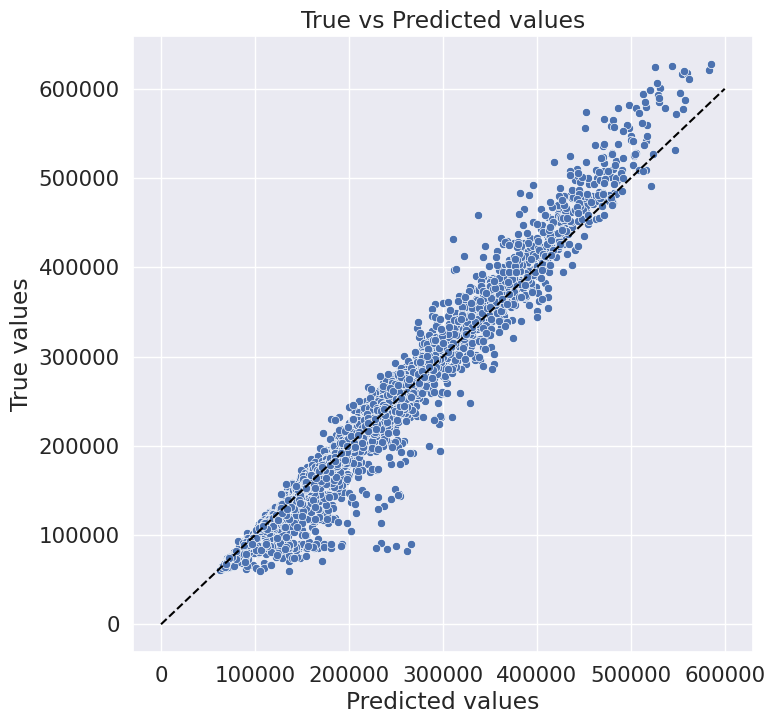

In [ ]:
model = RandomForestRegressor(criterion='squared_error',
                                 max_depth=20, # глубина дерева
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.718
RMSE:	50951.635
MSE:	2596069142.721


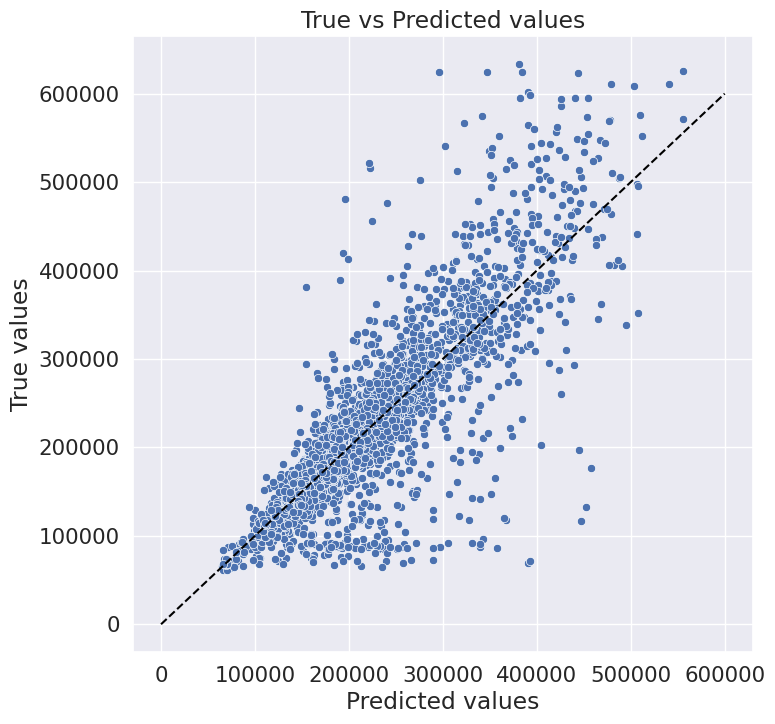

In [ ]:
y_test_preds = model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

##8. Настройка и оценка финальной модели

In [ ]:
X_train.shape[0] // 5

1340

In [ ]:
y_train.shape[0] // 5

1340

Для обеспечения соответствия индексов между признаками и целевой переменной

In [ ]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [ ]:
def k_fold_cross_validation(model):
    # Iteration_1
    X_train__val_1 = X_train.iloc[:1300]
    y_train__val_1 = y_train.iloc[:1300]

    X_train__train_1 = X_train.iloc[1300:]
    y_train__train_1 = y_train.iloc[1300:]

    model.fit(X_train__train_1, y_train__train_1)
    y__pred__val_1 = model.predict(X_train__val_1)

    R2__1 = r2(y__pred__val_1, y_train__val_1)

    # Iteration_2
    X_train__val_2 = X_train.iloc[1300:2600]
    y_train__val_2 = y_train.iloc[1300:2600]

    X_train__train_2 = X_train.drop(np.arange(1300, 2600))
    y_train__train_2 = y_train.drop(np.arange(1300, 2600))

    model.fit(X_train__train_2, y_train__train_2)
    y__pred__val_2 = model.predict(X_train__val_2)

    R2__2 = r2(y__pred__val_2, y_train__val_2)

    # Iteration_3
    X_train__val_3 = X_train.iloc[2600:3900]
    y_train__val_3 = y_train.iloc[2600:3900]

    X_train__train_3 = X_train.drop(np.arange(2600, 3900))
    y_train__train_3 = y_train.drop(np.arange(2600, 3900))

    model.fit(X_train__train_3, y_train__train_3)
    y__pred__val_3 = model.predict(X_train__val_3)

    R2__3 = r2(y__pred__val_3, y_train__val_3)

    # Iteration_4
    X_train__val_4 = X_train.iloc[3900:5200]
    y_train__val_4 = y_train.iloc[3900:5200]

    X_train__train_4 = X_train.drop(np.arange(3900, 5200))
    y_train__train_4 = y_train.drop(np.arange(3900, 5200))

    model.fit(X_train__train_4, y_train__train_4)
    y__pred__val_4 = model.predict(X_train__val_4)

    R2__4 = r2(y__pred__val_4, y_train__val_4)

    # Iteration_5
    X_train__val_5 = X_train.iloc[5200:6500]
    y_train__val_5 = y_train.iloc[5200:6500]

    X_train__train_5 = X_train.drop(np.arange(5200, 6500))
    y_train__train_5 = y_train.drop(np.arange(5200, 6500))

    model.fit(X_train__train_5, y_train__train_5)
    y__pred__val_5 = model.predict(X_train__val_5)

    R2__5 = r2(y__pred__val_5, y_train__val_5)

    return [R2__1, R2__2, R2__3, R2__4, R2__5]


Модель 1 (оригинальная)

In [ ]:
rf_model_1 = RandomForestRegressor(criterion='squared_error',
                                 max_depth=20, # глубина дерева
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )
R2_model_1 = k_fold_cross_validation(rf_model_1)
print(R2_model_1)
mean_R2_model_1 = np.mean(R2_model_1)
print(mean_R2_model_1)

[0.6057266623544753, 0.5908062741234643, 0.6035305803002244, 0.601811965317752, 0.5805333810903452]
0.5964817726372523


Модель 2 (меняем кол-во наблюдений в листе дерева)

In [ ]:
rf_model_2 = RandomForestRegressor(criterion='squared_error',
                                 max_depth=20, # глубина дерева
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )
R2_model_2 = k_fold_cross_validation(rf_model_2)
print(R2_model_2)
mean_R2_model_2 = np.mean(R2_model_2)
print(mean_R2_model_2)

[0.463089309084462, 0.4577730988256816, 0.4434573884430627, 0.4319859796568083, 0.42090975717442825]
0.4434431066368886


In [ ]:
dt_model = DecisionTreeRegressor()
R2_model_4 = k_fold_cross_validation(dt_model)
print(R2_model_4)
mean_R2_model_4 = np.mean(R2_model_4)
print(mean_R2_model_4)

[0.4414503544869225, 0.41229886720214226, 0.5069726085900281, 0.415547105599138, 0.42160300984784715]
0.4395743891452156


In [ ]:
lr_model = LinearRegression()
R2_model_5 = k_fold_cross_validation(lr_model)
print(R2_model_5)
mean_R2_model_5 = np.mean(R2_model_5)
print(mean_R2_model_5)

[0.128190864937613, 0.1684985847471887, 0.18312688354991669, 0.12566403049426078, 0.09609505582629296]
0.14031508391105443


In [ ]:
forest = RandomForestRegressor()
R2_model_7 = k_fold_cross_validation(forest)
print(R2_model_7)
mean_R2_model_7 = np.mean(R2_model_7)
print(mean_R2_model_7)

[0.5998430167484863, 0.5883010830739143, 0.60225993686601, 0.6077165814593823, 0.570085267785098]
0.5936411771865782


In [ ]:
gb_model_1 = GradientBoostingRegressor()
R2_model_8 = k_fold_cross_validation(gb_model_1)
print(gb_model_1)
mean_R2_model_8 = np.mean(R2_model_8)
print(mean_R2_model_8)

GradientBoostingRegressor()
0.5508783544882567


Переобучение

In [ ]:
model = RandomForestRegressor(criterion='squared_error',
                              min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                              random_state=42)

In [ ]:
%%time
params = {'n_estimators':[50, 100, 200, 400],
          'max_depth':[3, 10, 20, 30],
          'min_samples_leaf':[2, 5, 10, 20]}

gs = GridSearchCV(model, params,
                  scoring='r2', # метрика
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21,
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: user 24.8 s, sys: 907 ms, total: 25.7 s
Wall time: 6min 26s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 10, 20, 30],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [ ]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.209182,0.175426,0.027915,0.012855,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.518462,0.515793,0.561565,0.529978,0.539090,0.532978,0.016551,16
1,2.888633,0.537418,0.042599,0.019578,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.516742,0.517497,0.560255,0.530897,0.542404,0.533559,0.016363,15


In [ ]:
gs.best_params_

{'max_depth': 30, 'n_estimators': 400}

In [ ]:
gs.best_score_

0.7202388386381587

In [ ]:
final_model = GradientBoostingRegressor(criterion='squared_error',
                                        min_samples_leaf=1,  #минимальное кол-во наблюдений в листе дерева
                                        random_state=42,
                                        max_depth = 30,
                                        n_estimators = 400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', max_depth=30,
                          n_estimators=400, random_state=42)

R2:	1.0
RMSE:	404.078
MSE:	163279.169


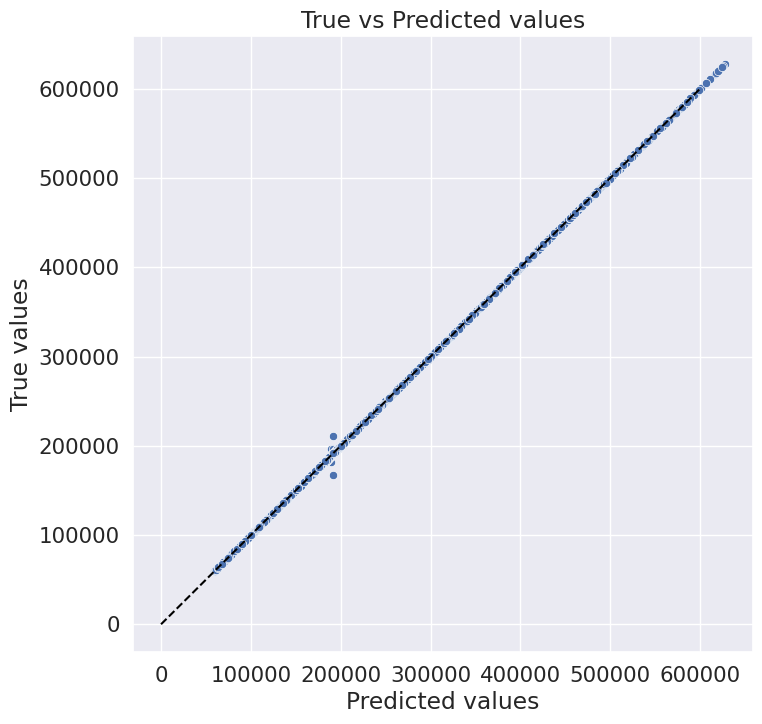

In [ ]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.507
RMSE:	67375.237
MSE:	4539422597.67


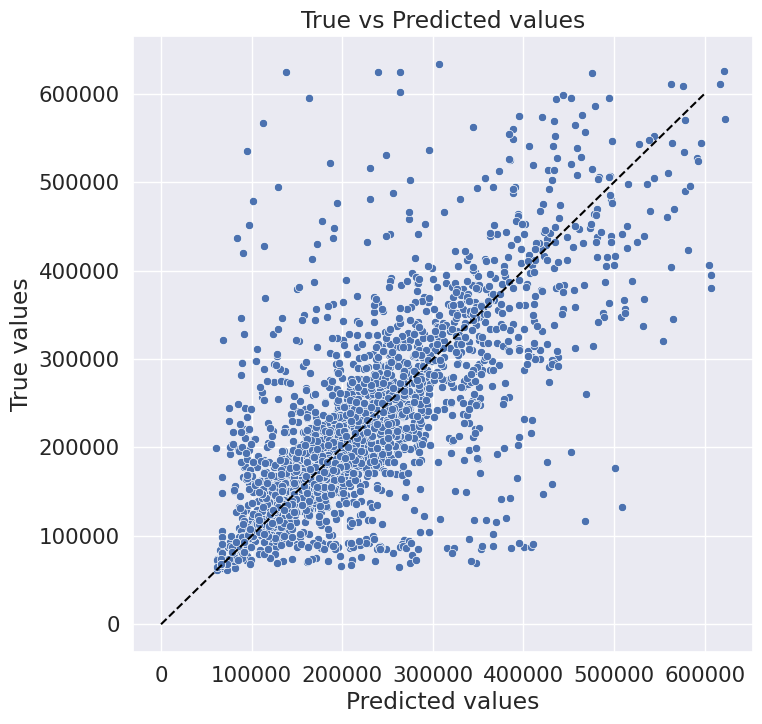

In [ ]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

##9. Анализ прогнозов

In [ ]:
final_model.feature_importances_

array([0.04386497, 0.0870687 , 0.36401199, 0.05005446, 0.02258487,
       0.02496408, 0.02601732, 0.03506243, 0.04220404, 0.08208189,
       0.1116068 , 0.06626054, 0.01569244, 0.00835782, 0.01892613,
       0.00124152])

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns,
                                       final_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

Топ 3 фичи

In [ ]:
feature_importances.head(3)

,feature_name,importance
2,Square,0.364012
10,Social_2,0.111607
1,Rooms,0.087069


Худшие 3 фичи

In [ ]:
feature_importances.tail(3)

,feature_name,importance
12,Healthcare_1,0.015692
13,Helthcare_2,0.008358
15,Shops_2_bin,0.001242


In [ ]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

##10. Сохранение

In [ ]:
#with open(SCALER_FILE_PATH, 'wb') as file:
#    pickle.dump(scaler1, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

NameError: name 'MODEL_FILE_PATH' is not defined

In [ ]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)

my_model

In [ ]:
import numpy as np

# Создание массива с размерностью (3, 1)
data = np.array([[1], [2], [3]])
print("Исходный массив:")
print(data)
print("Форма исходного массива:", data.shape)

# Удаление размерности с длиной 1
squeezed_data = np.squeeze(data)
print("\nМассив после удаления избыточной размерности:")
print(squeezed_data)
print("Форма массива после удаления избыточной размерности:", squeezed_data.shape)


Исходный массив:
[[1]
 [2]
 [3]]
Форма исходного массива: (3, 1)

Массив после удаления избыточной размерности:
[1 2 3]
Форма массива после удаления избыточной размерности: (3,)
